Import libraries necessary and parse XML file

In [1]:
import pandas as pd
import xmltodict
input_path = '/Users/antonythomas/Downloads/apple_health_export/export.xml'
with open(input_path, 'r') as xml_file:
    input_data = xmltodict.parse(xml_file.read())


Load into a Pandas Data frame

In [2]:
records_list = input_data['HealthData']['Record']
df = pd.DataFrame(records_list)

Filters Step Counts, Distance per Step (mi), Step Length data tables
Corrects data types for steps and date

In [3]:
step_counts = df[df['@type'] == 'HKQuantityTypeIdentifierStepCount']
step_counts = step_counts.drop(columns=['@sourceName','@sourceVersion', '@unit', '@device', 'MetadataEntry' ])

step_distance = df[df['@type'] == 'HKQuantityTypeIdentifierDistanceWalkingRunning']
step_distance = step_distance.drop(columns=['@sourceName','@sourceVersion', '@unit', '@device', 'MetadataEntry' ])

step_length = df[df['@type'] == 'HKQuantityTypeIdentifierWalkingStepLength']
step_length = step_length.drop(columns=['@sourceName','@sourceVersion', '@unit', '@device', 'MetadataEntry' ])

from datetime import datetime

format = '%Y-%m-%d %H:%M:%S %z'
step_counts['@creationDate'] = pd.to_datetime(step_counts['@creationDate'],format=format)
step_distance['@creationDate'] = pd.to_datetime(step_distance['@creationDate'],format=format)
step_length['@creationDate'] = pd.to_datetime(step_length['@creationDate'],format=format)

# group by date
step_counts['date'] = step_counts['@creationDate'].dt.date
step_counts['date'] = pd.to_datetime(step_counts['date'])
step_counts['@value'] = step_counts['@value'].astype(int)

step_distance['date'] = step_distance['@creationDate'].dt.date
step_distance['date'] = pd.to_datetime(step_distance['date'])
step_distance['@value'] = step_distance['@value'].astype(float)

step_length['date'] = step_length['@creationDate'].dt.date
step_length['date'] = pd.to_datetime(step_length['date'])
step_length['@value'] = step_length['@value'].astype(float)


Creates new data frame

In [4]:
new_df  = pd.DataFrame({
    'date': step_counts['date'],
    'steps': step_counts['@value']})

new_dis  = pd.DataFrame({
    'date': step_distance['date'],
    'distance in mi': step_distance['@value']})

stepsByDay = new_df.groupby(['date'])['steps'].sum()
distanceByDay = new_dis.groupby(['date'])['distance in mi'].sum()

test_df = stepsByDay.copy()
merged_df = pd.merge(test_df, distanceByDay, on='date')
merged_df = merged_df.reset_index(drop=False)


Aggregates all steps per day

In [5]:

merged_df.head()

,date,steps,distance in mi
0,2016-04-22,1372,0.572475
1,2016-04-23,5817,2.338842
2,2016-04-24,779,0.325773
3,2016-04-25,10685,4.673973
4,2016-04-26,8049,3.630058


Creates new columns 'distance_feet' and 'feet per step'

In [10]:
merged_df['distance_feet'] = merged_df['distance in mi'] * 5280.0
merged_df['feet per step'] = merged_df['distance_feet']/merged_df['steps']

In [11]:
merged_df.head()

,date,steps,distance in mi,distance_feet,feet per step
0,2016-04-22,1372,0.572475,3022.670112,2.203112
1,2016-04-23,5817,2.338842,12349.083859,2.122930
2,2016-04-24,779,0.325773,1720.078906,2.208060
3,2016-04-25,10685,4.673973,24678.578021,2.309647
4,2016-04-26,8049,3.630058,19166.706187,2.381253


Filters out 2023 data

In [12]:
merged_df = merged_df[merged_df['date'].dt.year != 2023]
merged_df.tail(10)

In [458]:
merged_df.info(0)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2417 entries, 0 to 2416
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   date            2417 non-null   datetime64[ns]
 1   steps           2417 non-null   int64         
 2   distance in mi  2417 non-null   float64       
 3   distance_feet   2417 non-null   float64       
 4   feet per step   2417 non-null   float64       
dtypes: datetime64[ns](1), float64(3), int64(1)
memory usage: 113.3 KB


In [14]:
from scipy.stats import f_oneway

steps_by_year = merged_df.groupby(merged_df['date'].dt.year)['steps'].sum()

# extract total steps and year from dataframe
total_steps = merged_df['steps']
year = merged_df['date'].dt.year

# perform ANOVA test
f_value, p_value = f_oneway(total_steps[year==2016], total_steps[year==2017], total_steps[year==2018], 
                            total_steps[year==2019], total_steps[year==2020], total_steps[year==2021],total_steps[year==2022])

# print results
print("F-value: ", f_value)
print("p-value: ", p_value)

F-value:  30.972595679489928
p-value:  5.1003728068770197e-36


<function matplotlib.pyplot.show(close=None, block=None)>

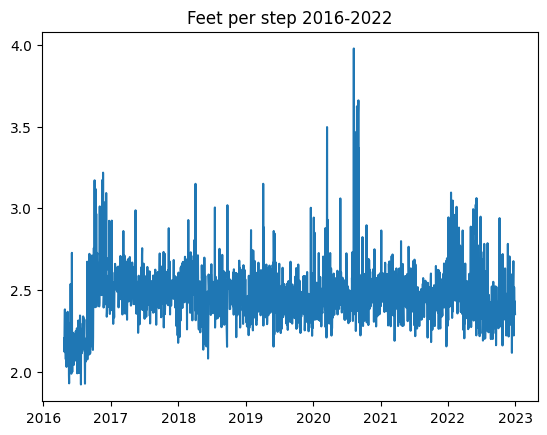

In [15]:
import matplotlib.pyplot as plt
fig = plt.figure()

# Draw a line plot of release_years and durations
plt.plot(merged_df['date'], merged_df['feet per step'])

# Create a title
plt.title("Feet per step 2016-2022")

# Show the plot
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

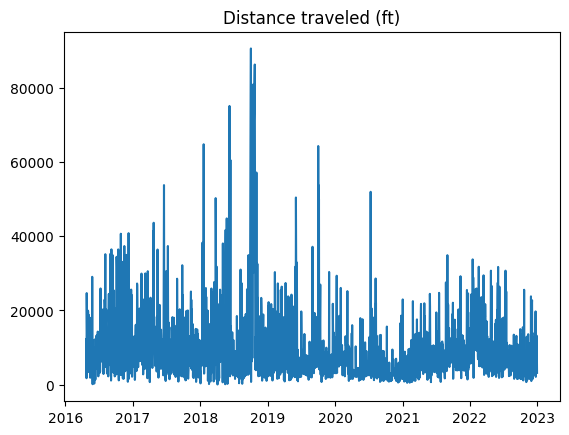

In [16]:
import matplotlib.pyplot as plt
fig = plt.figure()

# Draw a line plot of release_years and durations
plt.plot(merged_df['date'], merged_df['distance_feet'])

# Create a title
plt.title("Distance traveled (ft)")

# Show the plot
plt.show

In [17]:
import pytz

convert_tz = lambda x: x.to_pydatetime()
get_year = lambda x: convert_tz(x).year
get_month = lambda x: convert_tz(x).month
get_day = lambda x: convert_tz(x).day
get_hour = lambda x: convert_tz(x).hour
step_counts['@startDate'] = pd.to_datetime(step_counts['@startDate'])
step_counts['year'] = step_counts['@startDate'].map(get_year)
step_counts['month'] = step_counts['@startDate'].map(get_month)
step_counts['month'] = pd.to_datetime(step_counts['month'], format='%m').dt.strftime('%B')
step_counts['DayOfWeek'] = pd.to_datetime(step_counts['@startDate']).dt.strftime('%A')
step_counts['hour'] = step_counts['@startDate'].map(get_hour)

# print the dataframe
step_counts.tail(10)

,@type,@creationDate,@startDate,@endDate,@value,date,year,month,DayOfWeek,hour
74667,HKQuantityTypeIdentifierStepCount,2023-02-14 19:44:07-08:00,2023-02-14 19:33:05-08:00,2023-02-14 19:39:45 -0800,87,2023-02-14,2023,February,Tuesday,19
74668,HKQuantityTypeIdentifierStepCount,2023-02-14 19:56:28-08:00,2023-02-14 19:45:25-08:00,2023-02-14 19:49:59 -0800,23,2023-02-14,2023,February,Tuesday,19
74669,HKQuantityTypeIdentifierStepCount,2023-02-14 20:09:11-08:00,2023-02-14 19:57:27-08:00,2023-02-14 19:57:30 -0800,1,2023-02-14,2023,February,Tuesday,19
74670,HKQuantityTypeIdentifierStepCount,2023-02-14 21:14:52-08:00,2023-02-14 21:04:26-08:00,2023-02-14 21:11:13 -0800,40,2023-02-14,2023,February,Tuesday,21
74671,HKQuantityTypeIdentifierStepCount,2023-02-15 01:09:04-08:00,2023-02-15 00:58:56-08:00,2023-02-15 01:01:00 -0800,34,2023-02-15,2023,February,Wednesday,0
74672,HKQuantityTypeIdentifierStepCount,2023-02-15 10:19:19-08:00,2023-02-15 10:09:11-08:00,2023-02-15 10:11:12 -0800,46,2023-02-15,2023,February,Wednesday,10
74673,HKQuantityTypeIdentifierStepCount,2023-02-15 10:31:01-08:00,2023-02-15 10:19:58-08:00,2023-02-15 10:20:01 -0800,8,2023-02-15,2023,February,Wednesday,10
74674,HKQuantityTypeIdentifierStepCount,2023-02-15 11:26:12-08:00,2023-02-15 11:16:04-08:00,2023-02-15 11:16:12 -0800,9,2023-02-15,2023,February,Wednesday,11
74675,HKQuantityTypeIdentifierStepCount,2023-02-15 11:45:43-08:00,2023-02-15 11:34:41-08:00,2023-02-15 11:34:51 -0800,18,2023-02-15,2023,February,Wednesday,11
74676,HKQuantityTypeIdentifierStepCount,2023-02-15 12:28:21-08:00,2023-02-15 12:17:18-08:00,2023-02-15 12:17:21 -0800,10,2023-02-15,2023,February,Wednesday,12


In [22]:
#step_counts.to_csv(r'/Users/antonythomas/Downloads/samplehealth5.csv')

In [18]:
df_concat = pd.concat([step_counts, step_distance['@value']], axis=1)
step_counts = step_counts[step_counts['@startDate'].dt.year != 2023]

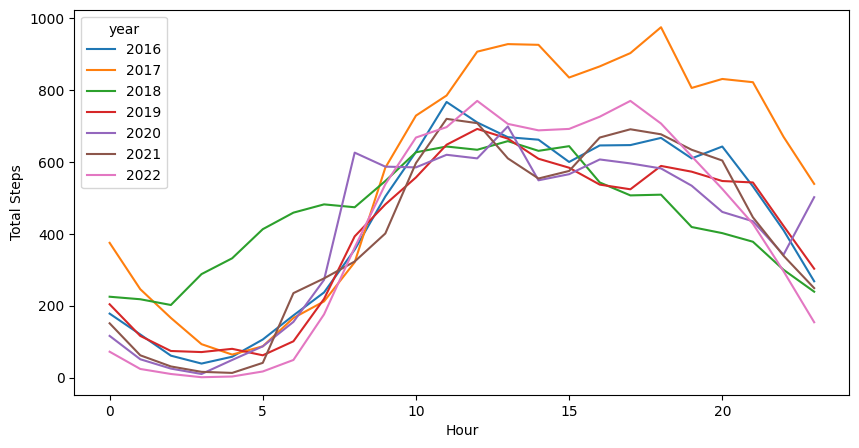

In [19]:
import matplotlib.pyplot as plt

year_hour_count = step_counts.groupby(['year', 'hour'])['@value'].count()

# unstack the resulting dataframe so that each year becomes a separate column
year_hour_count = year_hour_count.unstack(level=0)

# plot each year's data as a separate line on the same graph
year_hour_count.plot(kind='line', subplots=False, layout=(1,1), figsize=(10, 5))
plt.xlabel('Hour')
plt.ylabel('Total Steps')
plt.show()